# Notebook on Getting Explanations from a trained model


In [848]:
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from ase.visualize.plot import plot_atoms
from ase.visualize import view
from ase.io import read

import dgl
import torch

from bondnet.model.training_utils import (
    get_grapher,
    load_model_lightning,
)
from bondnet.data.utils import mol_graph_to_rxn_graph

def mols_from_reaction(dm, reactions, ids=0):
    product_wrapper = []
    reactant_wrapper = []
    reactions_batch = reactions[ids]
    #reaction_id = reactions_batch.id

    for i in reactions_batch.init_reactants:
        reactant_wrapper.append(
            dm.train_ds.dataset.reaction_network.molecule_wrapper[i]
        )
        #print(i, dm.train_ds.dataset.reaction_network.molecule_wrapper[i].id)

    for i in reactions_batch.init_products:
        # dm.train_ds.dataset.reaction_network.molecule_wrapper[i]
        # print(i)
        product_wrapper.append(dm.train_ds.dataset.reaction_network.molecule_wrapper[i])
        #print(i, dm.train_ds.dataset.reaction_network.molecule_wrapper[i].id)

    #pmg_reactants = [i.pymatgen_mol for i in reactant_wrapper]
    #pmg_products = [i.pymatgen_mol for i in product_wrapper]
    # get the 
    #return pmg_reactants, pmg_products, reactions[ids].atom_mapping, reactions_batch.bond_mapping
    #print(reactions[ids].atom_mapping == reactions_batch.atom_mapping)
    print(reactions_batch.init_products)
    print(reactions_batch.init_reactants)
    return reactant_wrapper, product_wrapper, reactions[ids].atom_mapping, reactions_batch.bond_mapping


def compute_person(features):
    """
    Compute the Pearson correlation coefficient.

    Args:
        ntype (str): the node type of the graph where the features are stored, e.g.
            `atom` and `bond`.
        exclude (list, optional): indices of features to ignore. This is useful to
            exclude features with 0 stdandard deviation. If `None`, nothing to
            exclude. Defaults to None.
    Returns:
        2D array: correlation between features
    """

    features = features.detach().numpy()
    # remove features with 0 standard deviation
    remove_idx = []
    for i in range(features.shape[1]):
        if np.std(features[:, i]) == 0:
            remove_idx.append(i)
    # remove features on remove_idx
    features = np.delete(features, remove_idx, axis=1)
    corr = np.corrcoef(features)
    return corr


def _split_batched_output(graph, value, n_type="bond"):
    """
    Split a tensor into `num_graphs` chunks, the size of each chunk equals the
    number of bonds in the graph.

    Returns:
        list of tensor.

    """
    nbonds = tuple(graph.batch_num_nodes(n_type).tolist())
    print(n_type, nbonds)
    split_tensor = torch.split(value, nbonds)
    # print(len(split_tensor))
    return split_tensor


def feature_at_each_layer(model, graph, feats, reactions, norm_atom, norm_bond):
    """
    Get the features at each layer before the final fully-connected layer.

    This is used for feature visualization to see how the model learns.

    Returns:
        dict: (layer_idx, feats), each feats is a list of
    """

    layer_idx = 0

    bond_feats = {}
    atom_feats = {}
    global_feats = {}

    feats = model.embedding(feats)
    bond_feats[layer_idx] = _split_batched_output(graph, feats["bond"], "bond")
    atom_feats[layer_idx] = _split_batched_output(graph, feats["atom"], "atom")
    global_feats[layer_idx] = _split_batched_output(graph, feats["global"], "global")

    layer_idx += 1

    # gated layer
    for layer in model.gated_layers:
        feats = layer(graph, feats, norm_atom, norm_bond)

        # store bond feature of each molecule
        bond_feats[layer_idx] = _split_batched_output(graph, feats["bond"], "bond")

        atom_feats[layer_idx] = _split_batched_output(graph, feats["atom"], "atom")

        global_feats[layer_idx] = _split_batched_output(
            graph, feats["global"], "global"
        )

        layer_idx += 1

    return bond_feats, atom_feats, global_feats



In [850]:
config = {
    "model": {
        "restore": True,
        "restore_path": "../../../data/models/best_model_filtered_reactions/model_lightning_epoch=208-val_l1=1.94.ckpt",  # path to ckpt
    }
}

model_restart = load_model_lightning(config["model"], load_dir="./test_save_load/")
model_restart.eval()

:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::


GatedGCNReactionNetworkLightning(
  (embedding): UnifySize(
    (linears): ModuleDict(
      (atom): Linear(in_features=20, out_features=12, bias=False)
      (bond): Linear(in_features=8, out_features=12, bias=False)
      (global): Linear(in_features=8, out_features=12, bias=False)
    )
  )
  (gated_layers): ModuleList(
    (0): GatedGCNConv(
      (activation): ReLU()
      (A): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=12, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Identity()
        )
      )
      (B): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=12, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Identity()
        )
      )
      (C): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=12, out_features=256, bias=Tru

In [851]:
! ls ../../../data/visualization_jsons/visualizing_node_features.json

../../../data/visualization_jsons/visualizing_node_features.json


In [880]:
import ast
df_test = pd.read_json("../../../data/visualization_jsons/visualizing_node_features.json")
print(df_test.columns)
#print(df_test["product_bonds"] == df_test["combined_product_bonds"])
#print(df_test["combined_product_bonds"] == df_test["product_bonds"])
#for i in df_test["combined_reactant_bonds"]:
#    print(len(i))    
##product_molecule_graph
#combined_products_graph
#combined_reactant_bonds
#product_bonds
#combined_product_bonds_global
#df_test["reactant_bonds"] = [ast.literal_eval(i) for i in df_test["combined_reactant_bonds"].tolist()]
df_test["product_bonds"] = [ast.literal_eval(i) for i in df_test["combined_product_bonds_local"].tolist()]
# save 
df_test.to_json("../../../data/visualization_jsons/visualizing_node_features_test.json")

Index(['reactant_id', 'reactant_charge', 'reactant_spin_multiplicity',
       'reactant_natoms', 'reactant_elements', 'reactant_nelements',
       'reactant_composition', 'reactant_formula_alphabetical',
       'reactant_chemsys', 'reactant_symmetry', 'deprecated',
       'reactant_smiles', 'reactant_structure', 'reactant_molecule_graph',
       'water_structure', 'water_molecule_graph', 'water_bonds',
       'reactant_bonds', 'reactant_opt_energy', 'reactant_sp_energy',
       'reactant_enthalpy', 'reactant_entropy', 'product_id', 'product_smiles',
       'reaction_id', 'functional_group_reacted', 'product_structure',
       'product_molecule_graph', 'product_bonds', 'product_opt_energy',
       'product_sp_energy', 'product_enthalpy', 'product_entropy', 'dE_opt',
       'dE_sp', 'dH', 'dS', 'dG_opt', 'dG_sp', 'reaction_atom_map',
       'bonds_broken', 'bonds_formed', 'mapping_dict',
       'combined_reactants_graph', 'combined_products_graph',
       'combined_product_bonds_local', 

In [881]:
print(df_test[df_test["reaction_id"] == "87312-83808"][[ "combined_reactant_bonds", "combined_product_bonds_global"]])
print(df_test[df_test["reaction_id"] == "87312-83808"][ "combined_reactant_bonds"].tolist())


                             combined_reactant_bonds  \
0  [[0, 1], [1, 8], [1, 2], [2, 4], [2, 7], [2, 3...   

                       combined_product_bonds_global  
0  [[0, 1], [1, 2], [1, 8], [2, 3], [2, 7], [2, 4...  
['[[0, 1], [1, 8], [1, 2], [2, 4], [2, 7], [2, 3], [3, 4], [3, 9], [3, 10], [4, 5], [5, 6], [5, 7], [7, 12], [7, 11], [13, 14], [13, 15]]']


In [882]:
df_test["reaction_id"]

0    87312-83808
1    87447-85287
2    26562-13726
3    69852-33152
4    63448-33772
5    75075-39157
6    75043-54872
7    67472-57709
8    22176-10097
9    77311-45803
Name: reaction_id, dtype: object

In [883]:
from bondnet.data.datamodule import BondNetLightningDataModule

dataset_loc = "../../../data/visualization_jsons/visualizing_node_features_test.json"

config = {
    "dataset": {
        "data_dir": dataset_loc,
        "target_var": "dG_sp",
    },
    "model": {
        "extra_features": ["bond_length"],
        "extra_info": [],
        "debug": False,
        "classifier": False,
        "classif_categories": 3,
        "filter_species": [3, 6],
        "filter_outliers": False,
        "filter_sparse_rxns": False,
        "restore": False,
    },
    "optim": {
        "val_size": 0.1,
        "test_size": 0.0,
        "batch_size": 1,
        "num_workers": 1,
    },
}

dm = BondNetLightningDataModule(config)
feat_size, feat_name = dm.prepare_data()
dm.setup(stage="validate")

fg_list None
reading file from: ../../../data/visualization_jsons/visualizing_node_features_test.json


rxn raw len: 10
Program finished in 0.5148567859996547 seconds
.............failures.............
reactions len: 10
valid ind len: 10
bond break fail count: 		0
default fail count: 		0
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 10
features: 22
labels: 10
molecules: 22
constructing graphs & features....
number of graphs valid: 22
number of graphs: 22


In [884]:
embedding_list = []

nodes = ["atom", "bond", "global"]
embedding_size = model_restart.hparams.embedding_size
batch_size = len(dm.train_ds)

direct_concat_name = model_restart.hparams.set2set_ntypes_direct
gat_out = model_restart.hparams.gated_hidden_size[-1]
readout_out_size = gat_out * 2 + gat_out * 2
readout_out_size += gat_out * len(direct_concat_name)
targets = []

for it, (batched_graph, label) in enumerate(dm.train_dataloader()):
    feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
    #print(feats["atom"].shape)
    target = label["value"].view(-1)

    norm_atom = label["norm_atom"]
    norm_bond = label["norm_bond"]
    stdev = label["scaler_stdev"]
    reactions = label["reaction"]
    targets.append(target)
    
    print(len(reactions[0].init_reactants), len(reactions[0].reactants), target)
    
    embeddings = model_restart.feature_before_fc(
        graph=batched_graph,
        feats=feats,
        reactions=reactions,
        norm_atom=norm_atom,
        norm_bond=norm_bond,
    )


1 1 tensor([-0.8610])
1 1 tensor([1.1956])
1 1 tensor([-1.3638])
1 1 tensor([-1.1206])
1 1 tensor([-0.0272])
1 1 tensor([1.2195])
1 1 tensor([0.8211])
2 2 tensor([-0.7903])
1 1 tensor([0.9622])


In [885]:
"""
preds = []  

for it, (batched_graph, label) in enumerate(dm.train_dataloader()):
    feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
    target = label["value"].view(-1)

    norm_atom = label["norm_atom"]
    norm_bond = label["norm_bond"]
    stdev = label["scaler_stdev"]
    reactions = label["reaction"]
    targets.append(target)
    pred = model_restart(
        graph=batched_graph,
        feats=feats,
        reactions=reactions,
        norm_atom=norm_atom,
        norm_bond=norm_bond,
    )
    preds.append(pred) 
"""

'\npreds = []  \n\nfor it, (batched_graph, label) in enumerate(dm.train_dataloader()):\n    feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}\n    target = label["value"].view(-1)\n\n    norm_atom = label["norm_atom"]\n    norm_bond = label["norm_bond"]\n    stdev = label["scaler_stdev"]\n    reactions = label["reaction"]\n    targets.append(target)\n    pred = model_restart(\n        graph=batched_graph,\n        feats=feats,\n        reactions=reactions,\n        norm_atom=norm_atom,\n        norm_bond=norm_bond,\n    )\n    preds.append(pred) \n'

In [886]:
print(reactions[0].reactants)
print(reactions[0].init_reactants)
print(reactions[0].id)


[0]
[6]
['2656213726']


In [887]:
print(len(pmg_products[0]), len(pmg_reactants[0]))

18 18


In [888]:
#pred_loss = model_restart.loss(pred.view(-1), target)
#pred_loss.backward()

In [889]:
# outputs are reactant then product feats for each node type

bond_feats, atoms_feats, global_feats = feature_at_each_layer(
    model=model_restart,
    graph=batched_graph,  # for a given set of graph feats
    feats=feats,  # and a given set of feats
    reactions=reactions,
    norm_atom=norm_atom,
    norm_bond=norm_bond,
)
unbatched_graph = dgl.unbatch(batched_graph)
# unbatched_graph = dgl.unbatch(batched_graph)
# print(len(unbatched_graph))

bond (20, 22)
atom (23, 23)
global (1, 1)
bond (20, 22)
atom (23, 23)
global (1, 1)
bond (20, 22)
atom (23, 23)
global (1, 1)


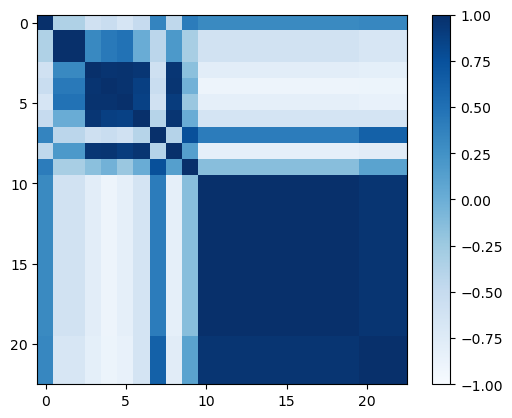

In [890]:
# change colors to blue to white 
plt.imshow(compute_person(atoms_feats[0][0]), cmap='Blues', vmin=-1, vmax=1)
plt.colorbar()

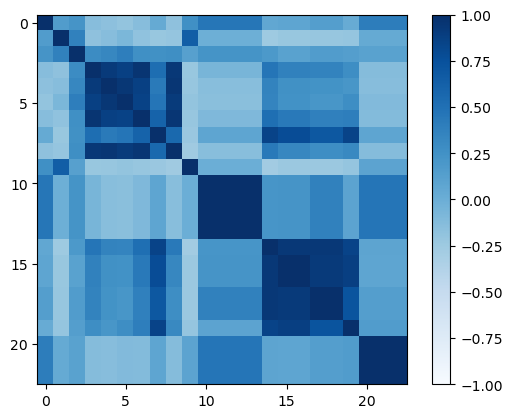

In [891]:

plt.imshow(compute_person(atoms_feats[1][0]), cmap='Blues', vmin=-1, vmax=1)
plt.colorbar()
# change colors to blue to white 


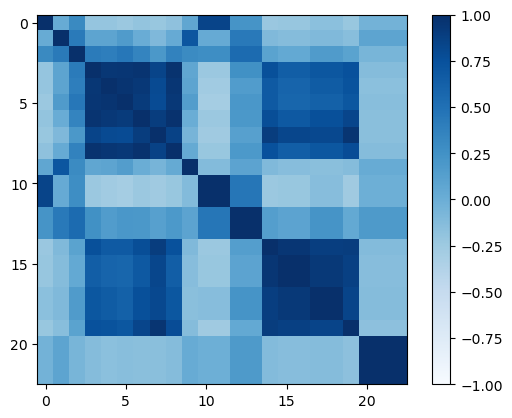

In [892]:
plt.imshow(compute_person(atoms_feats[2][0]), cmap='Blues', vmin=-1, vmax=1)
plt.colorbar()

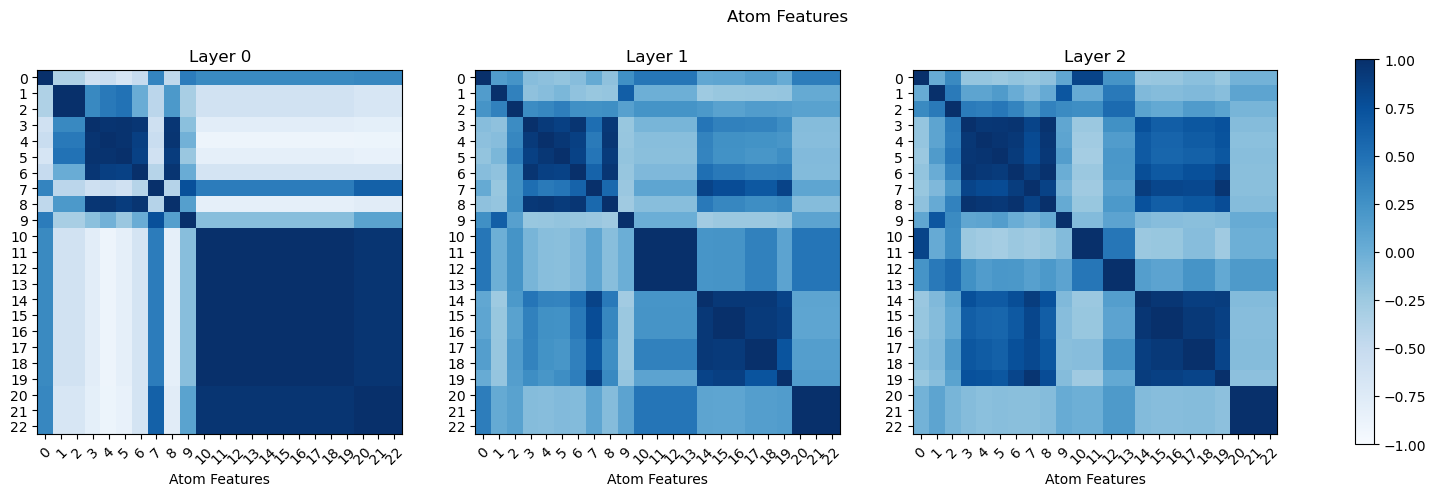

In [893]:
dims = atoms_feats[0][0].shape[0]
# make a subplot for each layer
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# firs tsubplot 
axs[0].imshow(compute_person(atoms_feats[0][0]), cmap='Blues', vmin=-1, vmax=1)
axs[0].set_title("Layer 0")
axs[0].set_xlabel("Atom Features")
#axs[0].set_ylabel("Atom Features")
# second subplot
axs[1].imshow(compute_person(atoms_feats[1][0]), cmap='Blues', vmin=-1, vmax=1)
axs[1].set_title("Layer 1")
axs[1].set_xlabel("Atom Features")
#axs[1].set_ylabel("Atom Features")
# third subplot
axs[2].imshow(compute_person(atoms_feats[2][0]), cmap='Blues', vmin=-1, vmax=1)
axs[2].set_title("Layer 2")
axs[2].set_xlabel("Atom Features")
#axs[2].set_ylabel("Atom Features")
# show all labels 
plt.suptitle("Atom Features")


# make subplot axis labels ints 
axs[0].set_xticks(np.arange(0, dims, 1))
# rotate the x axis labels
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[0].set_yticks(np.arange(0, dims, 1))
axs[1].set_xticks(np.arange(0, dims, 1))
for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
axs[1].set_yticks(np.arange(0, dims, 1))
axs[2].set_xticks(np.arange(0, dims, 1))
for tick in axs[2].get_xticklabels():
    tick.set_rotation(45)
axs[2].set_yticks(np.arange(0, dims, 1))
# add a colorbar for all subplots
fig.colorbar(axs[0].imshow(compute_person(atoms_feats[0][0]), cmap='Blues', vmin=-1, vmax=1), ax=axs.ravel().tolist())
#fig.show()

In [894]:
wrappers_reactants, wrappers_products, atom_mappings , bond_mappings = mols_from_reaction(dm, reactions, ids=0)

[7]
[6]


In [895]:
atom_mappings[0]

[{0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22}]

In [896]:
print(wrappers_reactants[0].bond_features)

{}


In [897]:
from bondnet.core.reaction_collection import get_molecules_from_reactions, get_atom_bond_mapping
reactions[0].total_bonds
reactions[0].total_atoms
#get_molecules_from_reactions(reactions[0])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [898]:
print(len(wrappers_reactants), len(wrappers_products))

1 1


In [899]:
ind_to_letter = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5:"F", 6:"G", 7:"H", 8:"I", 9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R", 18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Y", 25:"Z"}

def annotate_mol(mol, atom_mapping, bond_mapping):
    for ind, atom in enumerate(mol.GetAtoms()):
        #print atom index 
        atom.SetProp("atomNote", ind_to_letter[atom_mapping[ind]])
    # annotate bonds
    #print(mol.GetNumBonds())
    #for ind, bond in enumerate(mol.GetBonds()):
    #    print(ind, bond_mapping[ind])
    #    bond.SetProp("bondNote", str(bond_mapping[ind]))
    return mol

In [900]:
bond_mapping[0]

[[{0: 17,
   1: 18,
   2: 4,
   3: 15,
   4: 14,
   5: 9,
   6: 7,
   7: 16,
   8: 0,
   9: 13,
   10: 1,
   11: 8,
   12: 5,
   13: 19,
   14: 20,
   15: 11,
   16: 6,
   17: 10}],
 [{0: 17,
   1: 18,
   2: 4,
   3: 2,
   4: 10,
   5: 20,
   6: 0,
   7: 11,
   8: 6,
   9: 5,
   10: 19,
   11: 1,
   12: 13,
   13: 8,
   14: 16,
   15: 9,
   16: 7,
   17: 14,
   18: 3,
   19: 12}]]

In [901]:
pmg = pmg_reactants[0]
molblock = pmg.to("mol")
mol = Chem.MolFromMolBlock(molblock)
mol = annotate_mol(mol, atom_mapping[0][0], bond_mapping[0][0])
img = Draw.MolToImage(mol, size=(800, 800), kekulize=False,  showHs=False)

TypeError: unhashable type: 'dict'

In [902]:
pmg = pmg_products[0]
molblock = pmg.to("mol")
mol = Chem.MolFromMolBlock(molblock)
mol = annotate_mol(mol, atom_mapping[1][0], bond_mapping[1][0])
img = Draw.MolToImage(mol, size=(800, 800), showHs=False)
img 

IndexError: list index out of range

In [903]:
pmg

Molecule Summary
Site: O (1.0748, -1.2140, 0.6885)
Site: C (2.2260, -0.8152, 0.6439)
Site: O (2.5328, 0.3355, 1.2652)
Site: C (3.3247, -1.5536, -0.0041)
Site: C (4.7166, -1.0254, -0.1452)
Site: C (5.6243, -1.9705, 0.1294)
Site: C (4.9993, -3.2707, 0.5674)
Site: C (3.5080, -3.0436, 0.4056)
Site: O (2.7214, -3.6530, 1.3814)
Site: C (2.9616, -2.7213, -0.9260)
Site: H (3.4768, 0.5488, 1.2011)
Site: H (4.9412, -0.0123, -0.4833)
Site: H (6.7022, -1.8395, 0.0381)
Site: H (5.2337, -3.4929, 1.6197)
Site: H (5.3448, -4.1260, -0.0303)
Site: H (1.7908, -3.6213, 1.1198)
Site: H (3.5881, -2.8482, -1.8093)
Site: H (1.8929, -2.8931, -1.0627)

In [904]:
#molblock = pmg_products[0].to("mol")
#mol = Chem.MolFromMolBlock(molblock)


def plot_grid_ase(pmg_reactants, pmg_products, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i, pmg in enumerate(pmg_reactants):
        xyz_string = pmg.to("xyz")
        f = StringIO(xyz_string)
        atoms = read(f, format="xyz")
        plot_atoms(atoms, ax=axs[0], radii=0.3, rotation="45x,45y,45z")
        axs[0].set_title("Reactants")
        axs[0].axis("off")

    for i, pmg in enumerate(pmg_products):
        xyz_string = pmg.to("xyz")
        f = StringIO(xyz_string)
        atoms = read(f, format="xyz")        
        plot_atoms(atoms, ax=axs[1], radii=0.3, rotation="45x,45y,45z", )
        # add bonds
        axs[1].set_title("Products")
        axs[1].axis("off")
    plt.suptitle(title)
    plt.show()

def plot_grid_rdkit(pmg_reactants, pmg_products, atom_mappings, bond_mappings, title):
    max_molecules = max(len(pmg_reactants), len(pmg_products))
    fig, axs = plt.subplots(max_molecules, 2, figsize=(20, 8))
    
    for i, pmg in enumerate(pmg_reactants):
        molblock = pmg.to("mol")
        print(molblock.split("\n")[3].split(" ")[1])
        #print(molblock)
        mol = Chem.MolFromMolBlock(molblock, sanitize=False, removeHs=False)
        mol = annotate_mol(mol, atom_mappings[0][i], bond_mappings[0][i])
        #AllChem.EmbedMolecule(mol)
        
        #Draw.MolToMPL(mol, ax=axs[0])
        if max_molecules == 1:
            img = Draw.MolToImage(mol, size=(800, 800), showHs=False)
            axs[0].imshow(img)
            axs[0].set_title("Reactants")
            axs[0].axis("off")
        else:
            img = Draw.MolToImage(mol, size=(800, 800), showHs=False)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title("Reactants")
            axs[i, 0].axis("off")

    for i, pmg in enumerate(pmg_products):
        molblock = pmg.to("mol")
        #print(molblock)
        print(molblock.split("\n")[3].split(" ")[1])
        mol = Chem.MolFromMolBlock(molblock, sanitize=False, removeHs=False)
        # embed
        #AllChem.EmbedMolecule(mol)

        mol = annotate_mol(mol, atom_mappings[1][i], bond_mappings[1][i])
        #AllChem.EmbedMolecule(mol)
        
        #Draw.MolToMPL(mol, ax=axs[1])
        img = Draw.MolToImage(mol, size=(800, 800), showHs=False, )
        if max_molecules == 1:
            axs[1].imshow(img)
            axs[1].set_title("Products")
            axs[1].axis("off")
        else:
            axs[i, 1].imshow(img)
            axs[i, 1].set_title("Products")
            axs[i, 1].axis("off")

    plt.suptitle(title)
    plt.show()

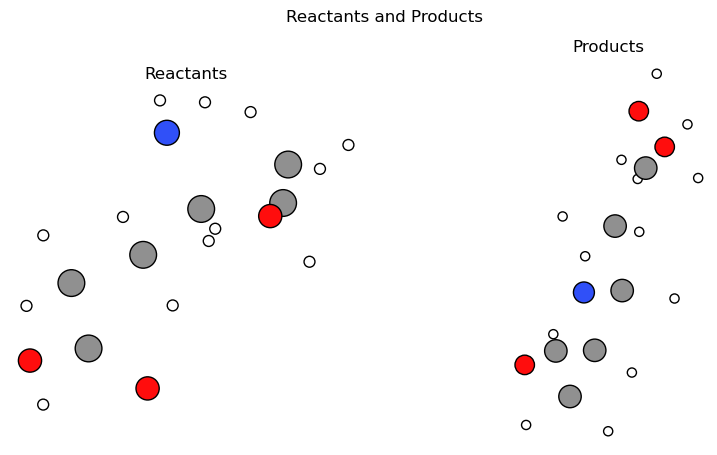

In [905]:
pmg_reactants = [i.pymatgen_mol for i in wrappers_reactants]
pmg_products = [i.pymatgen_mol for i in wrappers_products]
plot_grid_ase(pmg_reactants, pmg_products, "Reactants and Products")


23
23


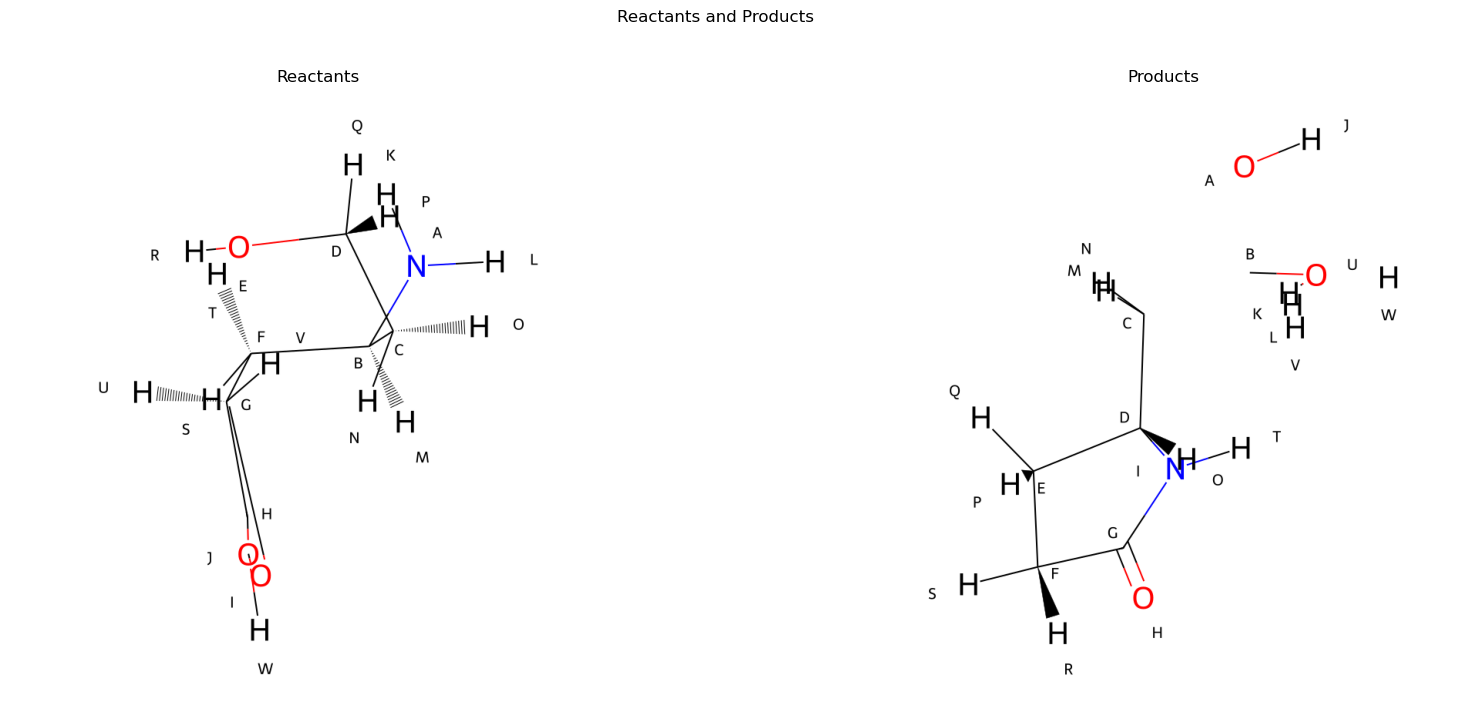

In [906]:
pmg_reactants = [i.pymatgen_mol for i in wrappers_reactants]
pmg_products = [i.pymatgen_mol for i in wrappers_products]
#atom_mapping = [i.atom_mapping for i in reactions]
#bond_mapping = [i.bond_mapping for i in reactions]
plot_grid_rdkit(pmg_reactants, pmg_products, atom_mappings, bond_mappings, "Reactants and Products")

In [661]:
# Gradient Analysis

In [134]:
def grad_at_each_layer(model, graph, feats, reactions, norm_atom, norm_bond, target):
    """
    Get the features at each layer before the final fully-connected layer.

    This is used for feature visualization to see how the model learns.

    Returns:
        dict: (layer_idx, feats), each feats is a list of
    """

    layer_idx = 0
    bond_grads = {}
    atom_grads = {}
    global_grads = {}

    pred = model(
        graph=graph,
        feats=feats,
        reactions=reactions,
        norm_atom=norm_atom,
        norm_bond=norm_bond,
    )
    dict_grads = {"embedding": {}, "gated": {}}

    model.loss(pred.view(-1), target).backward()
    
    linear_index = 0
    dict_grads["embedding"]["atom"] = model.embedding.linears["atom"].weight.grad
    dict_grads["embedding"]["bond"] = model.embedding.linears["bond"].weight.grad
    dict_grads["embedding"]["global"] = model.embedding.linears["global"].weight.grad

    # gated layer
    for layer in model.gated_layers:
        for name, param in layer.A.named_parameters():
            dict_grads["gated"]["A_" + name] = param.grad
        for name, param in layer.B.named_parameters():
            dict_grads["gated"]["B_" + name] = param.grad
        for name, param in layer.C.named_parameters():
            dict_grads["gated"]["C_" + name] = param.grad
        for name, param in layer.D.named_parameters():
            dict_grads["gated"]["D_" + name] = param.grad
        for name, param in layer.E.named_parameters():
            dict_grads["gated"]["E_" + name] = param.grad
        for name, param in layer.F.named_parameters():
            dict_grads["gated"]["F_" + name] = param.grad
        for name, param in layer.G.named_parameters():
            dict_grads["gated"]["G_" + name] = param.grad
        for name, param in layer.H.named_parameters():
            dict_grads["gated"]["H_" + name] = param.grad
        for name, param in layer.I.named_parameters():
            dict_grads["gated"]["I_" + name] = param.grad

    return dict_grads


dict_grads = grad_at_each_layer(
    model=model_restart,
    graph=batched_graph,
    feats=feats,
    reactions=reactions,
    norm_atom=norm_atom,
    norm_bond=norm_bond,
    target=target,
)

In [126]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

# this operates at the node level???
# this is just what nodes are activated
def saliency_map(input_grads):
    node_saliency_map = []
    for n in range(input_grads.shape[0]):  # nth node
        node_grads = input_grads[n, :]
        node_saliency = torch.norm(F.relu(node_grads)).item()
        node_saliency_map.append(node_saliency)
    return node_saliency_map
saliency_map(dict_grads["embedding"]["atom"])

"""def grad_cam(final_conv_acts, final_conv_grads):
    # print('grad_cam')
    node_heat_map = []
    alphas = torch.mean(
        final_conv_grads, axis=0
    )  # mean gradient for each feature (512x1)
    for n in range(final_conv_acts.shape[0]):  # nth node
        node_heat = F.relu(alphas @ final_conv_acts[n]).item()
        node_heat_map.append(node_heat)
    return node_heat_map


def ugrad_cam(n_atoms, final_conv_acts, final_conv_grads):
    # print('new_grad_cam')
    node_heat_map = []
    alphas = torch.mean(
        final_conv_grads, axis=0
    )  # mean gradient for each feature (512x1)
    for n in range(final_conv_acts.shape[0]):  # nth node
        node_heat = (alphas @ final_conv_acts[n]).item()
        node_heat_map.append(node_heat)

    node_heat_map = np.array(node_heat_map[:n_atoms]).reshape(-1, 1)
    pos_node_heat_map = (
        MinMaxScaler(feature_range=(0, 1))
        .fit_transform(node_heat_map * (node_heat_map >= 0))
        .reshape(
            -1,
        )
    )
    neg_node_heat_map = (
        MinMaxScaler(feature_range=(-1, 0))
        .fit_transform(node_heat_map * (node_heat_map < 0))
        .reshape(
            -1,
        )
    )
    return pos_node_heat_map + neg_node_heat_map"""

"def grad_cam(final_conv_acts, final_conv_grads):\n    # print('grad_cam')\n    node_heat_map = []\n    alphas = torch.mean(\n        final_conv_grads, axis=0\n    )  # mean gradient for each feature (512x1)\n    for n in range(final_conv_acts.shape[0]):  # nth node\n        node_heat = F.relu(alphas @ final_conv_acts[n]).item()\n        node_heat_map.append(node_heat)\n    return node_heat_map\n\n\ndef ugrad_cam(n_atoms, final_conv_acts, final_conv_grads):\n    # print('new_grad_cam')\n    node_heat_map = []\n    alphas = torch.mean(\n        final_conv_grads, axis=0\n    )  # mean gradient for each feature (512x1)\n    for n in range(final_conv_acts.shape[0]):  # nth node\n        node_heat = (alphas @ final_conv_acts[n]).item()\n        node_heat_map.append(node_heat)\n\n    node_heat_map = np.array(node_heat_map[:n_atoms]).reshape(-1, 1)\n    pos_node_heat_map = (\n        MinMaxScaler(feature_range=(0, 1))\n        .fit_transform(node_heat_map * (node_heat_map >= 0))\n        .res